In [1]:
import pathlib
import numpy as np
import pandas as pd
from scipy import sparse
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.base import clone
import loggingScoring as ls
import pickle
# not using logs for this one

### Load Data

In [2]:
datapath = pathlib.Path('..') / 'Data'
data_loader = np.load(datapath / 'PreprocessedData.npz')
X_train = sparse.csr_matrix((data_loader['X_train_data'],
                             data_loader['X_train_indices'],
                             data_loader['X_train_indptr']),
                            shape = data_loader['X_train_shape'])
y_train = data_loader['y_train']
X_test = sparse.csr_matrix((data_loader['X_test_data'],
                            data_loader['X_test_indices'],
                            data_loader['X_test_indptr']),
                           shape = data_loader['X_test_shape'])
y_test = data_loader['y_test']

### Model

This is the comparison of our 'Best' models so far for each classification algorithm (by accuracy, on test set):
1) Support Vector Machine - 0.962
2) Logistic Regression - 0.956
3) Gradient Boosting - 0.955
4) XGBoost - 0.944
5) Random Forest - 0.941
6) Multinomial Naive Bayes - 0.941

Clearly, SVM performed best. What I want to do here is try a couple of ensemble learners, like - Voting Classifier (Hard & Soft) and Stacking Classifier (again, Hard & Soft). An Ensemble Learner combines other (possibly weaker) learners to provide an overall better learner. Random Forest is an ensemble learner which combines decision trees (of various depths, splits etc.). Voting & Stacking classifiers are built on similar principles, however, they can combine other various classifiers - for instance, what I'll try here is combine an instance of the best performing SVM classifier, an instance of the best performing Logistic Regression classifier etc. Let's see if these ensemble models can outperform the best SVM model - if it succeeds, then that will be our best model, otherwise SVM wins that title.

Question is, which models to use as the building blocks of the Voting/Stacking classifiers. If we are just talking about individual models - we saw many SVM models that outperformed all the other best models mentioned here. Our best SVM model is built with rbf kernel - but there were other kernels with probable better scores than the other models here. But we shouldn't build an ensemble classifier with similar models, since the power of the ensemble model derives from the versatility of the underlying models. The models need to be different because even the ones which the most accurate model gets wrong, might be correctly identified by other (less accurate) models - and when we combine them, we allow ensemble model to harness the best from all.

I will test 2 combinations : 1) 3 base estimators - SVM (separate models for hard and soft voting methods), Logistic Regression, and Gradient Boosting; 2) 4 base estimators - SVM (separate models for hard and soft voting methods), Logistic Regression, Gradient Boosting, and Random Forest. I don't want to use XGB, mainly because I'm not sure how well will it play with sklearn, and it's accuracy score is not significantly better than what we achieved with Random Forest (also, I need to build more confidence with XGB).

I will try various combinations to find out the best performing set of parameters - in this phase I will restrict myself to training set only. Once the parameter combination is confirmed, only then will I train that model on the whole training set, and test it on the test set - to find out how it fares against the individual models.

Most importantly, these ensemble models are more complicated than individual models, and also less explainable. Hence, I will need a substantial jump in performance to justify these models. For instance, our best score (accuracy on the test set) is 0.962 provided by an SVM model - a soft (arguably, more complex than hard) ensemble model with a score of 0.963 will not justify the increase in complexity, and in such a case I will go back to the SVM model.

#### Voting Classifier

In [3]:
best_svm = SVC(kernel = 'rbf',
               C = 285.84,
               gamma = 0.8546,
               tol = 0.015,
               cache_size=1000,
               random_state=76)

# for probability prediction to be used in soft models
best_svm_prob = SVC(kernel = 'rbf',
                 C = 285.84,
                 gamma = 0.8546,
                 tol = 0.015,
                 probability=True,
                 cache_size=1000,
                 random_state=76)

best_logreg = LogisticRegression(solver = 'saga',
                                 penalty = 'elasticnet',
                                 C = 15,
                                 l1_ratio = 0,
                                 max_iter = 1000,
                                 # increased max_iter to handle "coef_ did not converge" errors
                                 # while being used in soft models
                                 random_state = 76)

best_gb = GradientBoostingClassifier(learning_rate = 0.16384,
                                     max_depth = 97,
                                     max_features = 235,
                                     min_samples_leaf = 6,
                                     min_samples_split = 142,
                                     n_estimators = 2514,
                                     random_state=76)

best_rf = RandomForestClassifier(max_depth = None,
                                 n_estimators = 400,
                                 max_features = 'log2',
                                 min_samples_leaf = 1,
                                 random_state = 76,
                                 n_jobs = -1)

list_3_estimators_hard = [('svm', best_svm), ('logreg', best_logreg), ('gb', best_gb)]
list_4_estimators_hard = [('svm', best_svm), ('logreg', best_logreg), ('gb', best_gb), ('rf', best_rf)]
list_3_estimators_soft = [('svm', best_svm_prob), ('logreg', best_logreg), ('gb', best_gb)]
list_4_estimators_soft = [('svm', best_svm_prob), ('logreg', best_logreg), ('gb', best_gb), ('rf', best_rf)]

In [4]:
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 76)
for voting in ['hard', 'soft']:
    for estimator_count in [3, 4]:
        start = time.time()
        if ((voting == 'hard') & (estimator_count == 3)):
            print('Voting Classifier with Hard Voting using 3 Estimators :')
            estimators = list_3_estimators_hard
        elif ((voting == 'hard') & (estimator_count == 4)):
            print('Voting Classifier with Hard Voting using 4 Estimators :')
            estimators = list_4_estimators_hard
        elif ((voting == 'soft') & (estimator_count == 3)):
            print('Voting Classifier with Soft Voting using 3 Estimators :')
            estimators = list_3_estimators_soft
        elif ((voting == 'soft') & (estimator_count == 4)):
            print('Voting Classifier with Soft Voting using 4 Estimators :')
            estimators = list_4_estimators_soft
        
        voting_classifier = VotingClassifier(estimators = estimators,
                                             voting = voting,
                                             verbose = False)
        
        scores = cross_val_score(estimator = voting_classifier,
                                 X = X_train,
                                 y = y_train,
                                 scoring = 'accuracy',
                                 cv = skf,
                                 verbose = 0)
        
        mean_score = round(scores.mean(), 5)
        end = time.time()
        time_taken = round((end - start), 3)
        print(f'Time Taken : {time_taken} s. Score : {mean_score}.')

Voting Classifier with Hard Voting using 3 Estimators :
Time Taken : 1508.717 s. Score : 0.96141.
Voting Classifier with Hard Voting using 4 Estimators :
Time Taken : 1320.514 s. Score : 0.96095.
Voting Classifier with Soft Voting using 3 Estimators :
Time Taken : 1872.269 s. Score : 0.95976.
Voting Classifier with Soft Voting using 4 Estimators :
Time Taken : 2022.224 s. Score : 0.9602.


[Voting] ...................... (1 of 3) Processing svm, total= 7.0min
[Voting] ................... (2 of 3) Processing logreg, total=  21.6s
[Voting] ....................... (3 of 3) Processing gb, total= 7.2min
Fit time: 874.925 s / Predict time: 43.862 s ---- Precision: 0.96 / Recall: 0.955 / Accuracy: 0.959

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.96      0.96      3187
        Fake       0.96      0.96      0.96      2936

    accuracy                           0.96      6123
   macro avg       0.96      0.96      0.96      6123
weighted avg       0.96      0.96      0.96      6123

ROC AUC Score : 0.9591780278190777


Confusion Matrix :



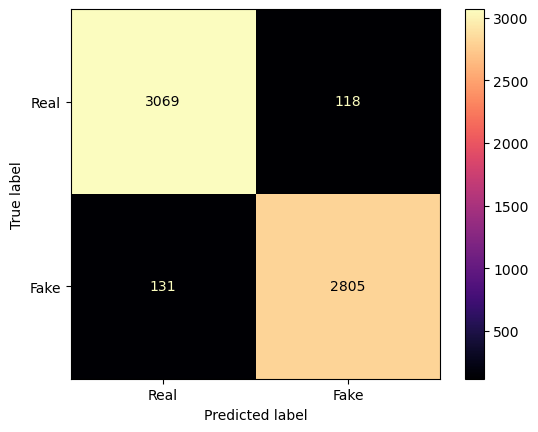

In [5]:
voting_classifier = VotingClassifier(estimators = list_3_estimators_hard,
                                     voting = 'hard',
                                     verbose = True)

start = time.time()
voting_model = voting_classifier.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = voting_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)

The best Voting Classifier's performance on the Test set could not beat best score of individual model (SVM, 0.962). Next, let's try Stacking Classifier.

#### Stacking Classifier
Similar to what I did with Voting Classifier - I want to try various options, and Stacking Classifier provides a lot of them. However, the bottleneck here is training time. For Voting Classifiers, hard models took around 10 mins to train (on the training set) and soft models took around 20 mins. However, I tried training Stacking Classifiers separately and they take 33 to 50 mins in similar situations while using cross validation (that the model provides) - and this restricts our ability to test out a lot of the options. We have an interesting option with Stacking Classifier to reduce training time though - we can pre-train the estimators, and that way since each time we want to try a different parameter of Stacking Classifier we reuse those same estimators - we will just need to spend time on training the Stacking Classifier itself. However, two problems with this approach -
1) The [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) are quite clear that the estimators and the Stacking Classifier itself should not be trained on the same data, since that can overfit quickly.
2) Also, when we are using this estimator pre-training, we won't be able to use the inbuilt cross validation provided by Stacking Classifier.

What I want from this exercise is to find out the best performing parameter combination based on accuracy, but I can't touch the test set to validate anything until I can confirm the model to use - once I confirm my parameters combination only then may I train a fresh model on the full training set and then test it on the test set. With that target in mind, I need to split my current training set - I will need a sizable chunk to pre-train the estimators, next big chunk will be used for training the Stacking Classifier itself (multiple times with various parameter combinations), and I will also need a relatively small portion to test out the performance of the ensemble model.

In [6]:
# Stacking Classifier Data Sets :
# Going to use 10% of the current training set as test for stacking classifier, this is actually 9% of the full dataset
# since current training set was split form the original dataset with 90/10 train/test split.
# From the remaining 81%, I'll set aside 35% as training set for Stacking Classifier itself
# this comes out around 28.35% of the full dataset.
# So, the estimators will be trained on roughly 52.65% of the original dataset.

X_train_stack_remaining, X_test_stack, y_train_stack_remaining, y_test_stack = train_test_split(X_train,
                                                                                                y_train,
                                                                                                stratify = y_train,
                                                                                                test_size = 0.1,
                                                                                                random_state = 76)
X_train_stack_estimators, X_train_stack_classifier, y_train_stack_estimators, y_train_stack_classifier = \
                                                                train_test_split(X_train_stack_remaining,
                                                                                 y_train_stack_remaining,
                                                                                 stratify = y_train_stack_remaining,
                                                                                 test_size = 0.35,
                                                                                 random_state = 76)
print(f'Shape of the Dataset on which Estimators will be Pre-Trained : {X_train_stack_estimators.shape}.')
print(f'Shape of the Dataset on which Stacking Classifier\'s Final Estimator will be Trained : {X_train_stack_classifier.shape}.')
print(f'Shape of the Dataset on which The Stacking Classifier will be evaluated : {X_test_stack.shape}.')

Shape of the Dataset on which Estimators will be Pre-Trained : (20296, 35003).
Shape of the Dataset on which Stacking Classifier's Final Estimator will be Trained : (10930, 35003).
Shape of the Dataset on which The Stacking Classifier will be evaluated : (3470, 35003).


In [7]:
# pre-training the estimators
svm_stack = clone(best_svm)
svm_prob_stack = clone(best_svm_prob)
logreg_stack = clone(best_logreg)
gb_stack = clone(best_gb)
rf_stack = clone(best_rf)

models_to_prefit = [
    ('svm', svm_stack),
    ('svm_prob', svm_prob_stack),
    ('logreg', logreg_stack),
    ('gb', gb_stack),
    ('rf', rf_stack)
]

list_stack_trained_3_hard, list_stack_trained_4_hard, list_stack_trained_3_soft, list_stack_trained_4_soft = [], [], [], []
for (name, estimator) in models_to_prefit:
    start = time.time()
    trained_model = estimator.fit(X_train_stack_estimators, y_train_stack_estimators)
    end = time.time()
    time_taken = round((end - start), 3)
    print(f'{name} model took {time_taken} secs to pre-fit.')
    if (name == 'svm'):
        list_stack_trained_3_hard.append((name, trained_model))
        list_stack_trained_4_hard.append((name, trained_model))
    elif (name == 'svm_prob'):
        list_stack_trained_3_soft.append((name, trained_model))
        list_stack_trained_4_soft.append((name, trained_model))
    elif (name == 'rf'):
        list_stack_trained_4_hard.append((name, trained_model))
        list_stack_trained_4_soft.append((name, trained_model))
    else:
        list_stack_trained_3_hard.append((name, trained_model))
        list_stack_trained_4_hard.append((name, trained_model))
        list_stack_trained_3_soft.append((name, trained_model))
        list_stack_trained_4_soft.append((name, trained_model))

print(f'Name of Hard Pre-Fit Models -')
print(f'3 estimators : {dict(list_stack_trained_3_hard).keys()}')
print(f'4 estimators : {dict(list_stack_trained_4_hard).keys()}')
print(f'Name of Soft Pre-Fit Models -')
print(f'3 estimators : {dict(list_stack_trained_3_soft).keys()}')
print(f'4 estimators : {dict(list_stack_trained_4_soft).keys()}')

svm model took 33.988 secs to pre-fit.
svm_prob model took 253.073 secs to pre-fit.
logreg model took 5.523 secs to pre-fit.
gb model took 342.516 secs to pre-fit.
rf model took 28.739 secs to pre-fit.
Name of Hard Pre-Fit Models -
3 estimators : dict_keys(['svm', 'logreg', 'gb'])
4 estimators : dict_keys(['svm', 'logreg', 'gb', 'rf'])
Name of Soft Pre-Fit Models -
3 estimators : dict_keys(['svm_prob', 'logreg', 'gb'])
4 estimators : dict_keys(['svm_prob', 'logreg', 'gb', 'rf'])


In [8]:
# list of final estimators to be used by Stacking Classifier
# provided parameters are just there to ensure that there is no obvious bottleneck
# these are (mostly) still the default classifiers
final_estimators = [
    ('Default', None),
    ('Random Forest', RandomForestClassifier(n_estimators = 1000,
                                             n_jobs = -1,
                                             random_state = 76)),
    ('Support Vector Machine', SVC(cache_size=1000,
                                   random_state=76)),
    ('Logistic Regression', LogisticRegression(max_iter = 1000,
                                               random_state = 76)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators = 1000,
                                                     random_state = 76)),
    ('Ada Boosting', AdaBoostClassifier(n_estimators = 1000,
                                        algorithm = 'SAMME',
                                        random_state = 76)),
    ('Extra Tree', ExtraTreesClassifier(n_estimators = 1000,
                                        max_features = None,
                                        # don't need this constraint with just 3/4 features (from 3/4 estimators)
                                        random_state = 76)),
    ('Hist Gradient Boosting', HistGradientBoostingClassifier(max_iter = 1000,
                                                              random_state = 76))
]

In [9]:
# skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 76)
identifier = ''
best_acc = 0
best_combo = []
for voting in ['hard', 'soft']:
    for estimator_count in [3, 4]:
        for (fe_name, final_estimator) in final_estimators:
            start = time.time()
            if ((voting == 'hard') & (estimator_count == 3)):
                identifier = f'Stacking Classifier with Hard Voting using 3 Estimators & {fe_name} as Final Estimator'
                estimators = list_stack_trained_3_hard
                stack_method = 'predict'
                # stacking classifier will call base models' predict method for hard stacking
            elif ((voting == 'hard') & (estimator_count == 4)):
                identifier = f'Stacking Classifier with Hard Voting using 4 Estimators & {fe_name} as Final Estimator'
                estimators = list_stack_trained_4_hard
                stack_method = 'predict'
            elif ((voting == 'soft') & (estimator_count == 3)):
                identifier = f'Stacking Classifier with Soft Voting using 3 Estimators & {fe_name} as Final Estimator'
                estimators = list_stack_trained_3_soft
                stack_method = 'predict_proba'
                # stacking classifier will call base models' predict_proba method for soft stacking
            elif ((voting == 'soft') & (estimator_count == 4)):
                identifier = f'Stacking Classifier with Soft Voting using 4 Estimators & {fe_name} as Final Estimator'
                estimators = list_stack_trained_4_soft
                stack_method = 'predict_proba'
        
            print(identifier + ' :')
            stacking_classifier = StackingClassifier(estimators = estimators,
                                                     stack_method = stack_method,
                                                     cv = 'prefit',
                                                     final_estimator = final_estimator)
            stacking_model = stacking_classifier.fit(X_train_stack_classifier, y_train_stack_classifier)
            end = time.time()
            fit_time = round((end - start), 3)
        
            start = time.time()
            preds = stacking_model.predict(X_test_stack)
            end = time.time()
            pred_time = round((end - start), 3)

            acc_score = round((sum(preds == y_test_stack) /  len(y_test_stack)), 5)
        
            print(f'Time taken to fit {fit_time} s, to predict {pred_time} s. Accuracy : {acc_score}.')
            
            if (acc_score > best_acc):
                best_acc = acc_score
                best_combo = []
                best_combo.append(identifier)
                print('Best Score so far !!!')
            elif (acc_score == best_acc):
                best_combo.append(identifier)
                print('Matched Previous Best Score.')
            else:
                print('Previous Best was unbeaten.')


print('*' * 125)
print(f'Best Accuracy of {best_acc} achieved with -')
for identifier in best_combo:
    print(identifier + '.')

Stacking Classifier with Hard Voting using 3 Estimators & Default as Final Estimator :
Time taken to fit 29.691 s, to predict 9.431 s. Accuracy : 0.96023.
Best Score so far !!!
Stacking Classifier with Hard Voting using 3 Estimators & Random Forest as Final Estimator :
Time taken to fit 32.57 s, to predict 9.764 s. Accuracy : 0.96023.
Matched Previous Best Score.
Stacking Classifier with Hard Voting using 3 Estimators & Support Vector Machine as Final Estimator :
Time taken to fit 29.684 s, to predict 10.925 s. Accuracy : 0.96023.
Matched Previous Best Score.
Stacking Classifier with Hard Voting using 3 Estimators & Logistic Regression as Final Estimator :
Time taken to fit 29.798 s, to predict 9.434 s. Accuracy : 0.96023.
Matched Previous Best Score.
Stacking Classifier with Hard Voting using 3 Estimators & Gradient Boosting as Final Estimator :
Time taken to fit 31.753 s, to predict 11.317 s. Accuracy : 0.96023.
Matched Previous Best Score.
Stacking Classifier with Hard Voting using 

We have not one, but 4 best performing Stacking Classifier models - all of them are using Soft voting on 4 classifiers, only difference is the final estimator. I have to try each of them out - this time the base estimators and final estimator all will be trained from scratch (no pre-trained models) with Cross Validation on the full training set.

In [11]:
# Best Accuracy of 0.96225 achieved with -
# Stacking Classifier with Soft Voting using 4 Estimators & Default as Final Estimator.

# fit
stacking_classifier = StackingClassifier(estimators = list_4_estimators_soft, # reverting back to old list of non-trained models
                                         stack_method = 'predict_proba',
                                         cv = skf,
                                         n_jobs = 2,
                                         verbose = 100)

start = time.time()
stacking_model = stacking_classifier.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 12.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  4.6min finished


Fit time: 2206.666 s / Predict time: 22.33 s ---- Precision: 0.961 / Recall: 0.96 / Accuracy: 0.963

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.96      0.96      3187
        Fake       0.96      0.96      0.96      2936

    accuracy                           0.96      6123
   macro avg       0.96      0.96      0.96      6123
weighted avg       0.96      0.96      0.96      6123

ROC AUC Score : 0.9625169605062802


Confusion Matrix :



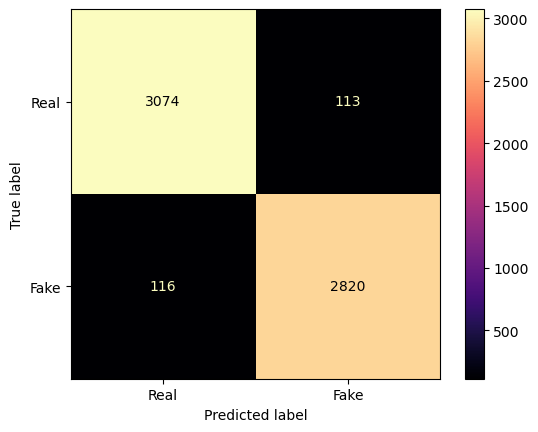

In [12]:
# Best Accuracy of 0.96225 achieved with -
# Stacking Classifier with Soft Voting using 4 Estimators & Default as Final Estimator.

# predict
start = time.time()
y_pred = stacking_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)

In [19]:
# Best Accuracy of 0.96225 achieved with -
# Stacking Classifier with Soft Voting using 4 Estimators & Support Vector Machine as Final Estimator.

# fit
stacking_classifier = StackingClassifier(estimators = list_4_estimators_soft,
                                         stack_method = 'predict_proba',
                                         cv = skf,
                                         final_estimator = SVC(cache_size=1000,
                                                               random_state=76),
                                         # n_jobs = 2, commented out due to following error :
                                         # UserWarning: A worker stopped while some jobs were given to the executor.
                                         # This can be caused by a too short worker timeout or by a memory leak.
                                         verbose = 100)

start = time.time()
stacking_model = stacking_classifier.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  7.7min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed: 15.8min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 22.7min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 22.7min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   18.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   26.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   26.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  9.1min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 15.5min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 15.5min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   31.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.6min


Fit time: 3843.639 s / Predict time: 22.971 s ---- Precision: 0.962 / Recall: 0.961 / Accuracy: 0.963

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.96      0.96      3187
        Fake       0.96      0.96      0.96      2936

    accuracy                           0.96      6123
   macro avg       0.96      0.96      0.96      6123
weighted avg       0.96      0.96      0.96      6123

ROC AUC Score : 0.9628441475886799


Confusion Matrix :



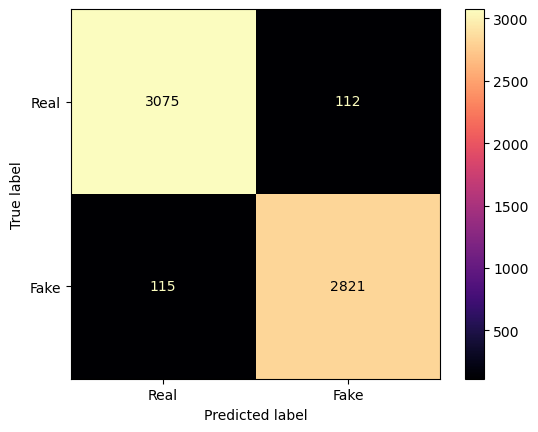

In [20]:
# Best Accuracy of 0.96225 achieved with -
# Stacking Classifier with Soft Voting using 4 Estimators & Support Vector Machine as Final Estimator.

# predict
start = time.time()
y_pred = stacking_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)

In [21]:
# Best Accuracy of 0.96225 achieved with -
# Stacking Classifier with Soft Voting using 4 Estimators & Logistic Regression as Final Estimator.

# fit
stacking_classifier = StackingClassifier(estimators = list_4_estimators_soft,
                                         stack_method = 'predict_proba',
                                         cv = skf,
                                         final_estimator = LogisticRegression(max_iter = 1000,
                                                                              random_state = 76),
                                         # n_jobs = 2,
                                         verbose = 100)

start = time.time()
stacking_model = stacking_classifier.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  5.4min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed: 11.4min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 17.1min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 17.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   17.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   26.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   26.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  8.6min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 15.3min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 15.3min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   41.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.1min


Fit time: 3464.669 s / Predict time: 31.887 s ---- Precision: 0.961 / Recall: 0.96 / Accuracy: 0.963

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.96      0.96      3187
        Fake       0.96      0.96      0.96      2936

    accuracy                           0.96      6123
   macro avg       0.96      0.96      0.96      6123
weighted avg       0.96      0.96      0.96      6123

ROC AUC Score : 0.9625169605062802


Confusion Matrix :



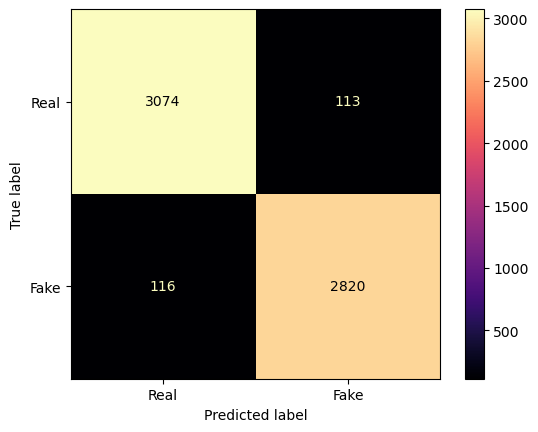

In [22]:
# Best Accuracy of 0.96225 achieved with -
# Stacking Classifier with Soft Voting using 4 Estimators & Logistic Regression as Final Estimator.

# predict
start = time.time()
y_pred = stacking_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)

In [17]:
# Best Accuracy of 0.96225 achieved with -
# Stacking Classifier with Soft Voting using 4 Estimators & Ada Boosting as Final Estimator.

# fit
stacking_classifier = StackingClassifier(estimators = list_4_estimators_soft,
                                         stack_method = 'predict_proba',
                                         cv = skf,
                                         final_estimator = AdaBoostClassifier(n_estimators = 1000,
                                                                              algorithm = 'SAMME',
                                                                              random_state = 76))

start = time.time()
stacking_model = stacking_classifier.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   12.6s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   23.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 13.0min finished


Fit time: 3035.697 s / Predict time: 23.219 s ---- Precision: 0.964 / Recall: 0.959 / Accuracy: 0.963

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.97      0.96      3187
        Fake       0.96      0.96      0.96      2936

    accuracy                           0.96      6123
   macro avg       0.96      0.96      0.96      6123
weighted avg       0.96      0.96      0.96      6123

ROC AUC Score : 0.9632611601627525


Confusion Matrix :



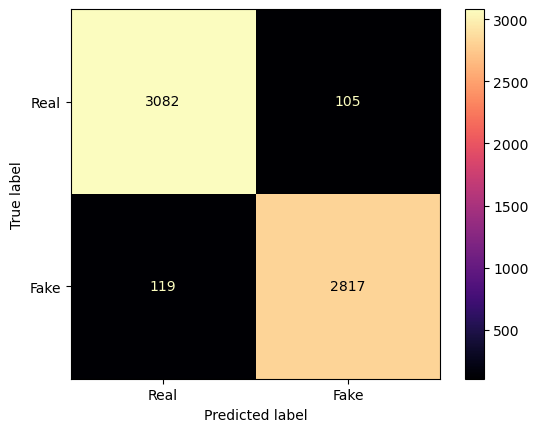

In [18]:
# Best Accuracy of 0.96225 achieved with -
# Stacking Classifier with Soft Voting using 4 Estimators & Ada Boosting as Final Estimator.

# predict
start = time.time()
y_pred = stacking_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)

As (kind of) predicted by our earlier test, each of the best performing (in our test) model performs almost equally well - 0.963 accuracy was achieved by each of them. But it was still worth checking anyway - as I have seen while cross validating thousands of models throughout the course of this project, cross validation accuracy is not always a good predictor of accuracy on test set (which is what we have been basing our decisions so far; in general, cross validation accuracy of a larger training set should generalize better).

Thing is, none of these scores (0.963 of Stacking Classifiers, Voting Classifier's score was actually worse than that of SVM) are a huge improvement over the accuracy of our best performing individual model (SVM, with accuracy of 0.962). As I mentioned earlier (didn't actually think that the best I would be able to achieve with these ensemble models would literally be 0.963 at that time), this minuscule improvement in score can not justify the increase in complexity that comes with these ensemble models. I would rather stick with the SVM model as our final one.

### Final Model

Fit time: 314.473 s / Predict time: 13.922 s ---- Precision: 0.963 / Recall: 0.958 / Accuracy: 0.962

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.97      0.96      3187
        Fake       0.96      0.96      0.96      2936

    accuracy                           0.96      6123
   macro avg       0.96      0.96      0.96      6123
weighted avg       0.96      0.96      0.96      6123

ROC AUC Score : 0.9619389994605128


Confusion Matrix :



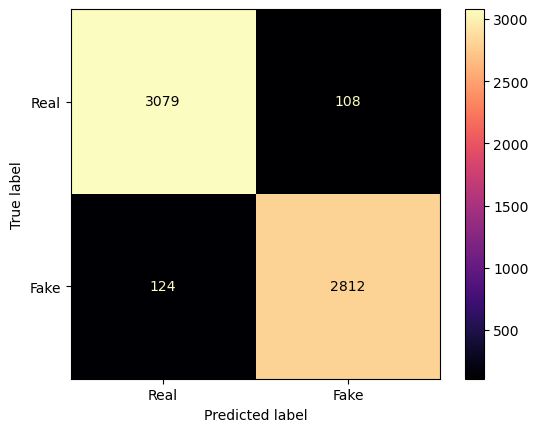

In [23]:
final_classifier = SVC(kernel = 'rbf',
                       C = 285.84,
                       gamma = 0.8546,
                       tol = 0.015,
                       cache_size=1000,
                       random_state=76)

start = time.time()
final_model = final_classifier.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = final_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)
# in hindsight, I have used this code-snippet so many times in this project, rather than putting just
# the test_results function, this whole thing should have been put in the logging&Scoring module

In [24]:
modelpath = pathlib.Path('..') / 'Model'
final_model_name = 'svm.pkl'
with open(modelpath / final_model_name, 'wb') as model_file:
    pickle.dump(final_model, model_file)